# Examples

This notebook demonstrates basic usage of the custom Session class, which implements most of the Marquee Studio API calls wrapped into convenience functions. The session object is initialized with client credentials, and is used to make API calls. We use a sample portfolio composed of equal weighted DJI index names.

In [1]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [11]:
from gs_quant.gs_utils import Session

#### Pass credentials and scope in a JSON file with the following format:

```json
{
 "auth_data": {
  "client_id": "",
  "client_secret": "",
  "scope": "read_content read_product_data read_financial_data
            modify_financial_data read_user_profile run_analytics",
  "grant_type": "client_credentials"
 },
 "auth_guid": ""
}
```

In [12]:
input_path = '/projects/'

#### Start the session

In [13]:
sess = Session(auth_json_filepath=input_path + 'auth.json', verbose=True)
sess.start(set_default_entitlements=True)

Access token: xnh6B7C72s12KbPRKvzlqhOjASUT


#### Load the portfolio

In [14]:
port = pd.read_csv(input_path + 'portfolio.csv')
port.head()

,quantity,positionDate,bbid
0,1960,01/28/19,AAPL UW
1,3108,01/28/19,AXP UN
2,801,01/28/19,BA UN
3,2460,01/28/19,CAT UN
4,6754,01/28/19,CSCO UW


### Upload dataframe buildout

This is the format of the dataframe to be uploaded:

|No  | quantity   | positionDate   | assetId             |
|:---|:-----------|:---------------|:--------------------|
|  0 |       2499 | 12/31/2017     | MA4B66MW5E27UANEQ6Q |
|  1 |       4708 | 12/31/2017     | MA4B66MW5E27UAKVA6N |
|  2 |       4520 | 12/31/2017     | MA9VHN7TW4A6YZ0P    |
|  3 |       2586 | 12/31/2017     | MA4B66MW5E27UAL9SUW |
|  4 |       5813 | 12/31/2017     | MA4B66MW5E27U9VBB93 |
|  * |       **** | ********       | ******************* |
| 99 |       2875 | 12/31/2017     | MA4B66MW5E27U9YGMGX |

#### Map the identifiers in the portfolio (`BBID` here) to the unique GS `assetId`

In [15]:
includes = ['id', 'name', 'currency', 'listed', 'xref', 'rank']

def get_df(gs_ids):
    ids_list = []
    for item in gs_ids:
        tmp = dict([(i, item[i]) for i in includes if i != 'xref'])
        tmp.update(item['xref'])
        ids_list.append(tmp)
    return pd.DataFrame(ids_list, columns=['id', 'name', 'currency',
                                           'listed', 'gsid', 'bbid',
                                           'bcid', 'ticker', 'rank'])

mapping_dict = sess.get_many_assets(bbid=port.bbid.unique(),
                                    assetClassificationsIsPrimary='true',
                                    listed='true',
                                    limit=300)['results']


mappings = get_df(mapping_dict)

In [16]:
print('Number of unique securities in portfolio: {}'.format(len(port.bbid.unique())))
print('Number of unique securities in mapping:   {}'.format(len(mappings.bbid.unique())))

Number of unique securities in portfolio: 30
Number of unique securities in mapping:   30


In [17]:
mappings.head()

,id,name,currency,listed,gsid,bbid,bcid,ticker,rank
0,MA4B66MW5E27UAHKG34,"The Goldman Sachs Group, Inc.",USD,True,901026,GS UN,GS US,GS,0.964215
1,MA4B66MW5E27U9ZPDFX,Boeing Co/the,USD,True,19561,BA UN,BA US,BA,0.861967
2,MA4B66MW5E27UAKHZFD,JPMorgan Chase & Co,USD,True,47896,JPM UN,JPM US,JPM,0.949960
3,MA4B66MW5E27UAHKGMA,Home Depot Inc,USD,True,66181,HD UN,HD US,HD,0.859566
4,MA4B66MW5E27UAL9SUX,Microsoft Corp,USD,True,10107,MSFT UW,MSFT US,MSFT,0.914048


#### Merge our portfolio with the retrieved mappings

In [18]:
port_mapped = port.merge(mappings[['id', 'bbid']], on='bbid')
port_mapped.head()

,quantity,positionDate,bbid,id
0,1960,01/28/19,AAPL UW,MA4B66MW5E27U9VBB94
1,1960,01/29/19,AAPL UW,MA4B66MW5E27U9VBB94
2,1960,01/30/19,AAPL UW,MA4B66MW5E27U9VBB94
3,1960,01/31/19,AAPL UW,MA4B66MW5E27U9VBB94
4,3108,01/28/19,AXP UN,MA4B66MW5E27U9ZPDCJ


In [19]:
port_mapped = port_mapped.drop('bbid', axis=1).rename({'id':'assetId'}, axis=1)
port_mapped.head()

,quantity,positionDate,assetId
0,1960,01/28/19,MA4B66MW5E27U9VBB94
1,1960,01/29/19,MA4B66MW5E27U9VBB94
2,1960,01/30/19,MA4B66MW5E27U9VBB94
3,1960,01/31/19,MA4B66MW5E27U9VBB94
4,3108,01/28/19,MA4B66MW5E27U9ZPDCJ


#### Upload the portfolio

In [20]:
portfolio_id = sess.upload_portfolio(port_mapped,
                                     port_name='Test Portfolio',
                                     start_date=port_mapped.positionDate.min())

Portfolio ID: MP54T92ZF3K103F4


#### Create and Schedule Portfolio Reports

Let's set the _measures_ and _parameters_ for the **Portfolio Performance Analytics** report

In [21]:
pa_measures=['pnl', 'longExposure', 'shortExposure',
             'assetCount', 'turnover', 'assetCountLong',
             'assetCountShort', 'netExposure', 'grossExposure',
             'tradingPnl', 'tradingCostPnl', 'servicingCostLongPnl',
             'servicingCostShortPnl']
pa_parameters={
    'transactionCostModel': 'FIXED',
    'servicingCostLong': 0,
    'servicingCostShort': 200,
    'tradingCost': 8
}

Marquee automatically creates a **Portfolio Performance Analytics** report. We can either create a new one

In [22]:
ppa_report = sess.create_report(positionSourceId=portfolio_id,
                                type='Portfolio Performance Analytics',
                                positionSourceType='Portfolio',
                                measures=pa_measures,
                                parameters=pa_parameters)

Or update the Marquee-generated one with our parameters

In [23]:
# get the default Portfolio Performance Analytics report
ppa_report = sess.get_portfolio_reports(portfolio_id)['results'][0]
ppa_report.update({'parameters':pa_parameters})
ppa_report.update({'measures':pa_measures})
sess.update_report(**ppa_report)

{}

We can create a **Portfolio Factor Risk** report

In [24]:
pfr_report = sess.create_risk_report(portfolio_id=portfolio_id,
                                     start_date=port_mapped.positionDate.min(),
                                     end_date=port_mapped.positionDate.max(),
                                     risk_model='AXUS4M')

And we schedule report execution, which will run analytics for all dates across all positions between a given start and end date. For the **Portfolio Performance Analytics** report, setting the startDate to anything after T-1 **or** using the built-in batching function produces an error.

In [27]:
sess.schedule_report(ppa_report['id'],
                     startDate=port_mapped.positionDate.min() - datetime.timedelta(days=3),
                     endDate=port_mapped.positionDate.max(),
                     batch=None)

Schedule report execution for the **Portfolio Risk Report**, setting `batch='weekly'` or `batch='monthly'` to speed up the execution

In [29]:
sess.schedule_report(pfr_report['id'],
                     startDate=port_mapped.positionDate.min(),
                     endDate=port_mapped.positionDate.max(),
                     batch='weekly')

Check the execution status

In [32]:
sess.get_portfolio_reports(portfolio_id, return_df=True)[['positionSourceName',
                                                          'positionSourceId','type',
                                                          'status','createdTime',
                                                          'lastUpdatedTime','id']]

,positionSourceName,positionSourceId,type,status,createdTime,lastUpdatedTime,id
0,Test Portfolio,MP54T92ZF3K103F4,Portfolio Performance Analytics,done,2019-02-15T21:18:03.153Z,2019-02-15T21:18:03.153Z,RPZCC0TSHNDDHPGX
1,Test Portfolio,MP54T92ZF3K103F4,Portfolio Factor Risk,done,2019-02-15T21:19:10.525Z,2019-02-15T21:19:10.525Z,RP3CYPKQGTPWN4NA


#### We can list the portfolios

In [42]:
sess.get_many_portfolios(return_df=True, limit=50) \
    .sort_values('createdTime', ascending=False)[['name', 'id', 'createdTime']].head(1)

,name,id,createdTime
0,Test Portfolio,MP54T92ZF3K103F4,2019-02-15T21:18:03.152Z


#### Or search by name

In [47]:
sess.search_portfolios(q='Test Portfolio',
                       name='Test Portfolio',
                       return_df=True)[['name', 'id', 'createdTime']]

,name,id,createdTime
0,Test Portfolio,MP54T92ZF3K103F4,2019-02-15T21:18:03.152Z


#### And retreive the reports we just generated

In [48]:
portfolio_id = 'MP54T92ZF3K103F4'
ppa_report = sess.search_reports(q=portfolio_id,
                 positionSourceId=portfolio_id,
                 reportType='Portfolio Performance Analytics')['results'][0]

pfr_report = sess.search_reports(q=portfolio_id,
                 positionSourceId=portfolio_id,
                 reportType='Portfolio Factor Risk')['results'][0]

In [62]:
ppa_data = sess.get_data(dataSetId='PPA',
                         reportId=ppa_report['id'],
                         startDate='2000-01-01',
                         endDate='2020-12-31',
                         return_df=True)

pfr_data = sess.get_data(dataSetId='PFR',
                         reportId=pfr_report['id'],
                         startDate='2000-01-01',
                         endDate='2020-12-31',
                         return_df=True)

#### View Portfolio Performance Analytics data

In [63]:
ppa_data.head()

,assetCount,assetCountLong,assetCountShort,date,grossExposure,longExposure,netExposure,pnl,reportId,reportRunTime,servicingCostLongPnl,servicingCostShortPnl,shortExposure,tradingCostPnl,tradingPnl,turnover
0,30.0,30.0,0.0,2019-01-28,9583192.80,9583192.80,9583192.80,-7666.554240,RPZCC0TSHNDDHPGX,2019-02-15T21:25:58Z,0.0,0.0,0.0,-7.666554e+03,-7.666554e+03,9.583193e+06
1,30.0,30.0,0.0,2019-01-29,9599163.29,9599163.29,9599163.29,15970.490000,RPZCC0TSHNDDHPGX,2019-02-15T21:25:58Z,0.0,0.0,0.0,-5.587940e-13,-5.587940e-13,6.980000e-10
2,30.0,30.0,0.0,2019-01-30,9730429.09,9730429.09,9730429.09,131265.800000,RPZCC0TSHNDDHPGX,2019-02-15T21:25:58Z,0.0,0.0,0.0,-4.656610e-13,-4.656610e-13,5.820000e-10
3,30.0,30.0,0.0,2019-01-31,9729706.76,9729706.76,9729706.76,2102.848048,RPZCC0TSHNDDHPGX,2019-02-15T21:25:58Z,0.0,0.0,0.0,-2.261952e+00,-2.261952e+00,2.827440e+03


#### View Portfolio Factor Risk data

In [64]:
pfr_data.head()

,annualRisk,dailyRisk,date,exposure,factor,factorCategory,mctr,pnl,reportId,reportRunTime,sensitivity
0,NaN,NaN,2019-01-29,9599163.29,1006,Market,1.001358,-10249.481711,RP3CYPKQGTPWN4NA,2019-02-15T21:26:43Z,104552.654254
1,NaN,NaN,2019-01-30,9730429.09,1006,Market,1.000098,121330.969518,RP3CYPKQGTPWN4NA,2019-02-15T21:26:43Z,105971.888507
2,NaN,NaN,2019-01-31,9729706.76,1006,Market,1.002974,84854.847852,RP3CYPKQGTPWN4NA,2019-02-15T21:26:43Z,106272.012355
3,NaN,NaN,2019-01-29,600680.19,142,IND,0.005784,10420.891678,RP3CYPKQGTPWN4NA,2019-02-15T21:26:43Z,4349.148253
4,NaN,NaN,2019-01-30,622300.76,142,IND,0.006079,-1977.254534,RP3CYPKQGTPWN4NA,2019-02-15T21:26:43Z,4476.362799


Plot cumulative P&L and exposure over time

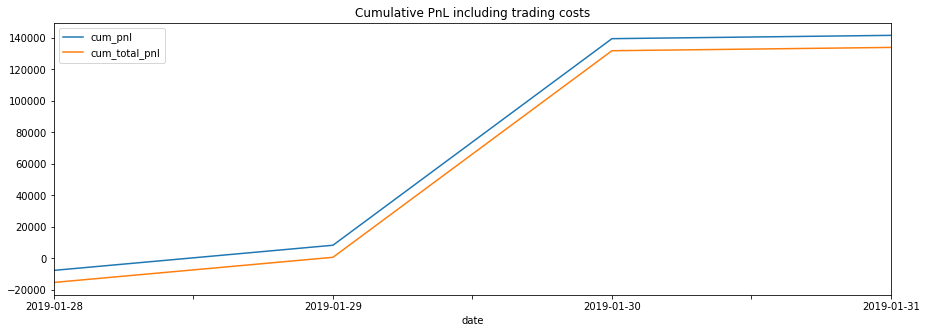

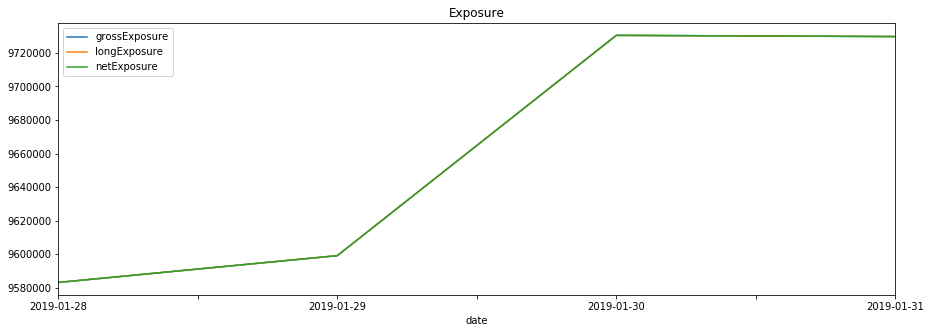

In [66]:
ppa_pnl_cols = [col for col in ppa_data.columns if 'pnl' in col.lower()]
for col in ppa_pnl_cols:
    ppa_data['cum_{}'.format(col)] = ppa_data[col].cumsum()
ppa_data['cum_total_pnl'] = ppa_data['cum_pnl'] + ppa_data['cum_tradingPnl']
ppa_data.plot(x='date', y=['cum_pnl', 'cum_total_pnl'], figsize=(15,5),
              title='Cumulative PnL including trading costs')
ppa_data.plot(x='date', y=['grossExposure',
                           'longExposure',
                           'netExposure'], figsize=(15,5),
              title='Exposure')
plt.show()

Close the session

In [ ]:
sess.close_session()